# Analyzer

In [3]:
import pandas as pd
import numpy as np
import os

import matplotlib.pyplot as plt
import matplotlib as mpl 
import seaborn as sns

mpl.rcParams['figure.dpi']= 200
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

from skmisc.loess import loess

import statsmodels.api as sm
import statsmodels.formula.api as smf

import ipystata
from ipystata.config import config_stata  
config_stata('/Applications/Stata/StataMP.app/Contents/MacOS/stata-mp')  
from IPython.display import Image

from rpy2.robjects import pandas2ri
pandas2ri.activate()

%reload_ext rpy2.ipython

In [4]:
PATH = "/Volumes/Extreme SSD/data/analysis"

df = pd.read_pickle(os.path.join(PATH, 'vendor_week.pickle'))
df = df.merge(df.groupby('vendor')['me_min'].min().rename('me'), on = 'vendor')

In [5]:
df.columns

Index(['vendor', 'w', 'rating_m', 'reputation_m', 'price_usd_m', 'delta_t_m',
       'neg_rating_m', 'count_min', 'neg_count_min', 'pos_count_min',
       'price_usd_s', 'delta_t_s', 'cum_count', 'arf', 'arf_bgm', 'neg_rating',
       'international_shipment', 'item_count', 'item_count_w',
       'category_count', 'category_count_w', 'price_diff_mw', 'arm_maxw',
       'arm_bgm_maxw', 'empty_stock_last_week_maxw', 'me_min', 'neg_count_w',
       'pos_count_w', 'has_price_drop', 'sales_volume_w', 'arm_maxw_shift',
       'arm_bgm_maxw_shift', 'has_price_drop_shift', 'me'],
      dtype='object')

In [6]:
cols = ['vendor', 'w', 'neg_count_min', 'pos_count_min', 'arf']
container = []
for vendor in [1, 61]:
    container.append(df.loc[df['vendor'] == vendor, cols].head())

pd.concat(container).reset_index(drop = True)

,vendor,w,neg_count_min,pos_count_min,arf
0,1,1,3.0,11.0,False
1,1,2,5.0,45.0,False
2,1,3,16.0,102.0,False
3,1,4,19.0,143.0,False
4,1,5,22.0,164.0,False
5,61,1,13.0,1.0,True
6,61,2,69.0,124.0,True
7,61,29,79.0,215.0,True
8,61,30,79.0,446.0,True
9,61,32,79.0,448.0,True


# Negative Feedbacks

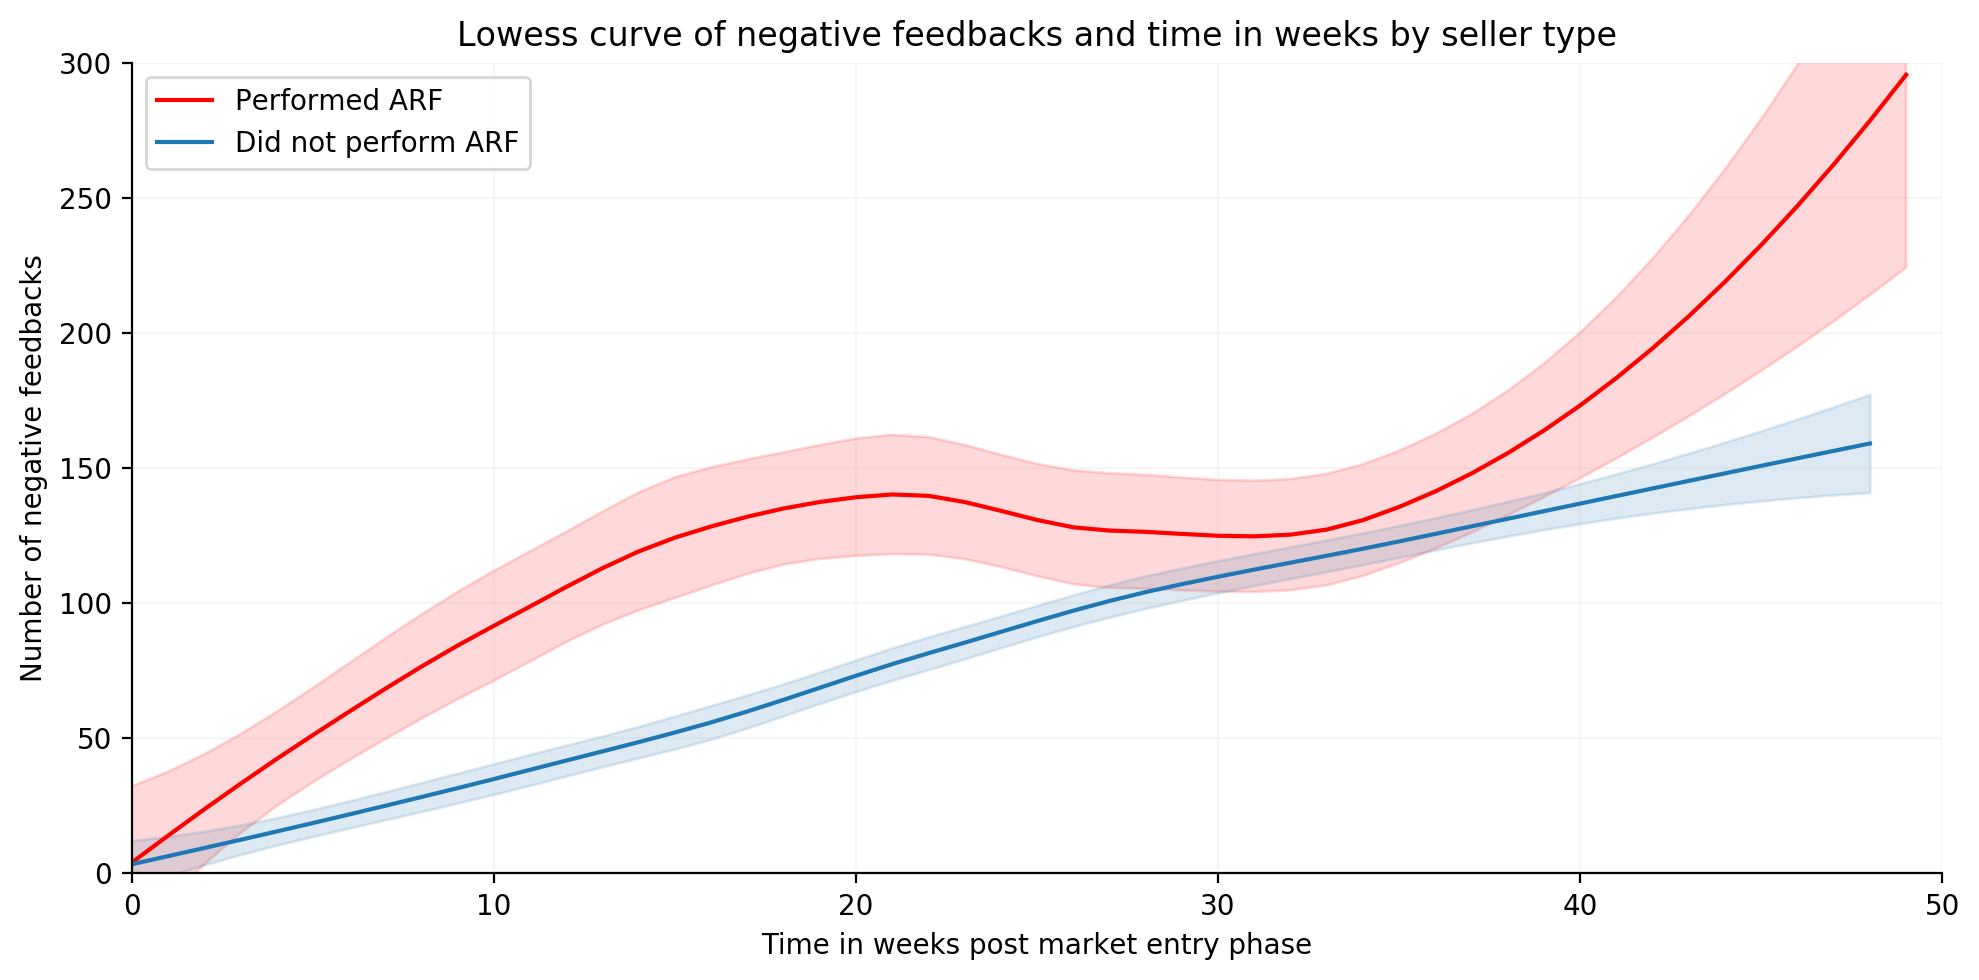

In [7]:
fig, ax = plt.subplots(figsize =  [10, 5])
ax.grid(True, which="both", ls="-", alpha = .1)

s = [df['arf'], ~df['arf']]
c = ['red', '#1f77b4']
l = ['Performed ARF', 'Did not perform ARF']

for selection, color, label in zip(s, c, l):
    # preprocess data
    data = df[selection].sort_values('w').copy()
    y = data['neg_count_min'].to_numpy()
    x = data['w'] - 2
    x_ = x.unique()

    # fit and predict lowess curve
    l = loess(x.to_numpy(), y, frac=0.1)
    l.fit()
    pred  = l.predict(x_, stderror=True)
    val   = pred.values
    conf  = pred.confidence()
    lower = conf.lower
    upper = conf.upper

    # plot lowess curve with 95% confidence
    ax.plot(x_, val, color=color, label = label)
    ax.fill_between(x_, lower, upper, alpha=.15, color=color)

ax.set_xlim(0, 50)
ax.set_ylim(0, 300)

# set titles and axes labels
ax.set_title('Lowess curve of negative feedbacks and time in weeks by seller type')
ax.set_ylabel('Number of negative feedbacks')
ax.set_xlabel('Time in weeks post market entry phase')
ax.legend(loc = 'upper left')

# show plot
plt.tight_layout()
plt.show()

In [8]:
df = df.sort_values(['vendor', 'w'])
df['neg_count'] = df.groupby('vendor')\
    .apply(lambda x: x['neg_count_min'] - x['neg_count_min'].shift())\
    .reset_index(drop = True)\
    .fillna(df['neg_count_min'])

df['pos_count'] = df.groupby('vendor')\
    .apply(lambda x: x['pos_count_min'] - x['pos_count_min'].shift())\
    .reset_index(drop = True)\
    .fillna(df['pos_count_min'])

In [9]:
df.loc[df['sales_volume_w'].isna(), 'sales_volume_w'] = df['count_min']

In [10]:
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer()

# normalize variables
skewed_variables = ['neg_count_min', 'pos_count_min', 'neg_count', 'pos_count', 'item_count', 'count_min']

bc_vars = pd.DataFrame(
    pt.fit_transform(df[skewed_variables]),
    columns = ['bc_' + var for var in skewed_variables])
bc_vars = pd.concat([bc_vars, pd.DataFrame(
    pt.fit_transform(df[['sales_volume_w', 'item_count_w']]),
    columns = ['bc_sales_volume_w', 'bc_item_count_w'])], 
         axis = 1)

c_vars = df[skewed_variables].add_prefix('c_')

dummy_vars = df.assign(
        items   = pd.qcut(df['item_count'], 3,  labels=["low", "medium", "high"]),
        items_w = pd.qcut(df['item_count_w'], 3,  labels=["low", "medium", "high"]),
        sales   = pd.qcut(df['cum_count'], 2,  labels=["low", "high"]),
        sales_w = pd.qcut(df['sales_volume_w'], 2,  labels=["low", "high"]))\
    .loc[:,['items', 'items_w', 'sales', 'sales_w']]

n_vars = df[['cum_count', 'sales_volume_w', 'item_count', 'item_count_w', 'me']].rename({'cum_count': 'sales_volume'})

bool_vars = df[
    ['arf', 'arf_bgm', 'arm_maxw', 'arm_maxw_shift', 'arm_bgm_maxw_shift',
     'international_shipment', 'has_price_drop', 'has_price_drop_shift']].astype('int')

lev_vars =  df[['vendor','w', 'me_min']]

data = pd.concat([lev_vars, bool_vars, bc_vars, c_vars, dummy_vars, n_vars], axis = 1)

In [19]:
data.to_csv("/Volumes/Extreme SSD/data/analysis/data.csv")

In [13]:
%%stata -d data

ppmlhdfe c_neg_count 

ppmlhdfe c_neg_count,                                       ///
    cluster(vendor w)
    
ppmlhdfe c_neg_count bc_pos_count                           ///
      item_count_w c.sales_volume_w international_shipment  ///
      has_price_drop c.me##c.me c.w##c.w,                   ///
    cluster(vendor w)
    
ppmlhdfe c_neg_count bc_pos_count arf                       ///
      item_count_w c.sales_volume_w international_shipment  ///
      has_price_drop c.me##c.me c.w##c.w,                   ///
    cluster(vendor w)
    
margins, dydx(*)


Iteration 1:   deviance = 3.8479e+05  eps = .         iters = 1    tol = 1.0e-04  min(eta) =  -1.00  PS  
Iteration 2:   deviance = 3.4199e+05  eps = 1.25e-01  iters = 1    tol = 1.0e-04  min(eta) =  -1.50   S  
Iteration 3:   deviance = 3.3912e+05  eps = 8.48e-03  iters = 1    tol = 1.0e-04  min(eta) =  -1.67   S  
Iteration 4:   deviance = 3.3910e+05  eps = 6.27e-05  iters = 1    tol = 1.0e-04  min(eta) =  -1.69   S  
Iteration 5:   deviance = 3.3910e+05  eps = 4.22e-09  iters = 1    tol = 1.0e-05  min(eta) =  -1.69   S O
------------------------------------------------------------------------------------------------------------
(legend: p: exact partial-out   s: exact solver   h: step-halving   o: epsilon below tolerance)
Converged in 5 iterations and 5 HDFE sub-iterations (tol = 1.0e-08)

PPML regression                                   No. of obs      =     23,682
                                                  Residual df     =     23,681
                                     

# ARM

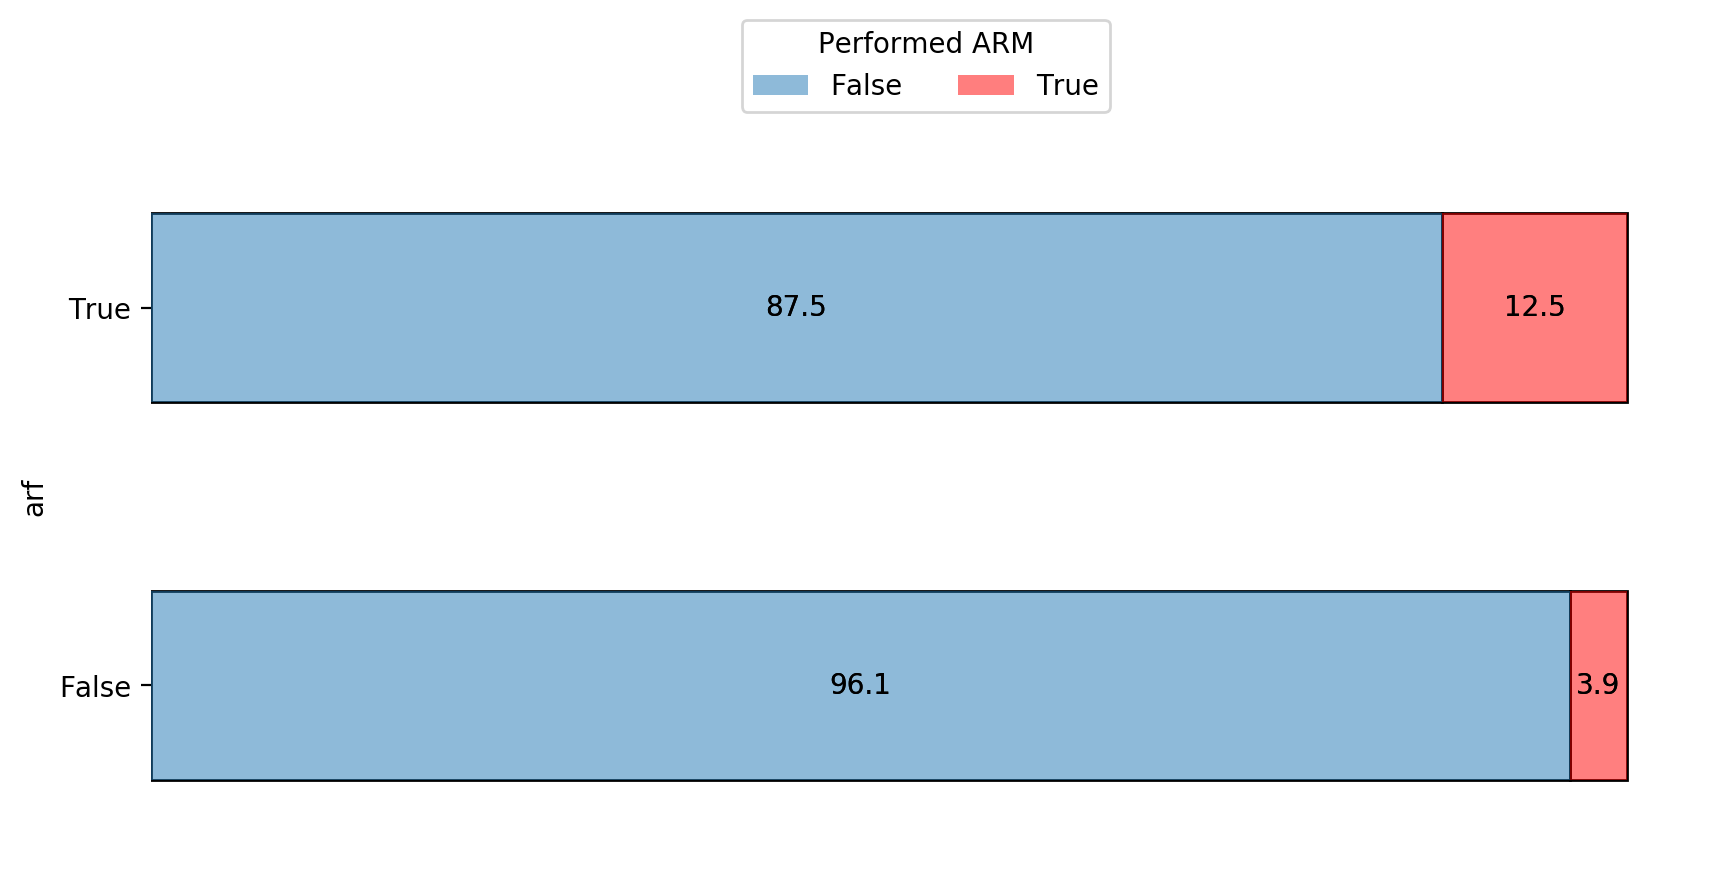

In [23]:
ct = pd.crosstab(df['arf'], df['arm_maxw'], normalize = 'index')

fig, ax = plt.subplots(figsize =  [10, 5])
ax.invert_yaxis()

ct.plot.barh(stacked = True, 
             ax = ax, 
             edgecolor = 'black',
             color = ['none', 'none'])
ct.plot.barh(stacked = True, 
             ax = ax,
             rot = 0, 
             color = ['#1f77b4', 'red'],
             alpha = .5) 

# make legends for right panel 
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(), 
          loc='upper center', bbox_to_anchor=(0.5, 1.15), 
          ncol = 2, title = 'Performed ARM')

# Value labels
patches = ax.patches
for rect in patches:
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., round(width*100, 1), ha='center', va='center')

ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
plt.xticks([])
plt.show()

In [83]:
%%R -i data -o model2_fit

library('lme4')
library('tidyverse')

# standardize time variables
data['me_'] <- scale(data$me)
data['w_'] <- scale(data$w)
data['me_2'] <- scale(data$me^2)
data['w_2'] <- scale(data$w^2)

# Create empty list for results
model2 <- list()

# Baseline Model
model2 <- append(model2, 
                 list(a = glm(arm_maxw_shift ~ 0,
                              data, 
                              family = binomial)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# empty
model2 <- append(model2, 
                 list(b = glmer(arm_maxw_shift ~ 0
                                + (1 | vendor),
                                data, 
                                family = binomial)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# Including control variables
model2 <- append(model2, 
                 list(c = glmer(arm_maxw_shift ~ 0
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# without interaction with bobyqa optimization
Optimizer <- glmerControl(optimizer = "bobyqa",
                          optCtrl = list(maxfun=2e5))

model2 <- append(model2, 
                 list(d = glmer(arm_maxw_shift ~ bc_neg_count + arf
                                + bc_sales_volume_w + factor(international_shipment) 
                                + factor(has_price_drop) + me_ + me_2 + w_ + w_2
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial,
                                control = Optimizer)))


# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted)
# cross-level-interaction of ARF and Negative Feedbacks with 
# bobyqa optimization
model2 <- append(model2, 
                 list(e = glmer(arm_maxw_shift ~ bc_neg_count*arf
                                + bc_sales_volume_w + factor(international_shipment) 
                                + factor(has_price_drop) + me_ + me_2 + w_ + w_2
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial, 
                                control = Optimizer)))

# Model comparison 
model2_fit <- round(data.frame(t(anova(model2$b, model2$c, model2$d, model2$e))), 3)

In [81]:
%%R -o model2_res
model2_res <- round(data.frame(summary(model2$e)[10]),3)
colnames(model2_res) <- c("B", 'se', 'z', 'p')
model2_res['or'] <- round(exp(model2_res$B), 3)
rownames(model2_res) <- c('Intercept', '#Negative feedbacks per week', 'ARF', 
                    '#sales per week', 'International Shipment', 
                    'Lowering of Selling Prices', 'Market Entry (in week since t0)',
                    'Market Entry (in weeks since t0)^2', 'Weeks since market entry phase', 
                    'Weeks since market entry phase^2', '#Negative feedbacks per week * ARF')

In [84]:
model2_fit

,model2.b,model2.c,model2.d,model2.e
npar,1.000,2.000,12.000,13.000
AIC,12785.925,6551.423,5959.866,5932.770
BIC,12793.998,6567.568,6056.736,6037.712
logLik,-6391.963,-3273.712,-2967.933,-2953.385
deviance,12783.925,6547.423,5935.866,5906.770
Chisq,NaN,6236.502,611.557,29.096
Df,NaN,1.000,10.000,1.000
Pr(>Chisq),NaN,0.000,0.000,0.000


In [82]:
model2_res

,B,se,z,p,or
Intercept,-4.716,0.269,-17.556,0.000,0.009
#Negative feedbacks per week,0.955,0.051,18.816,0.000,2.599
ARF,0.302,0.370,0.817,0.414,1.353
#sales per week,0.296,0.059,5.045,0.000,1.344
International Shipment,0.196,0.158,1.239,0.216,1.217
Lowering of Selling Prices,-1.226,0.210,-5.840,0.000,0.293
Market Entry (in week since t0),0.726,0.209,3.481,0.000,2.067
Market Entry (in weeks since t0)^2,-0.251,0.187,-1.345,0.179,0.778
Weeks since market entry phase,-4.326,0.783,-5.522,0.000,0.013
Weeks since market entry phase^2,4.093,0.698,5.860,0.000,59.919


## Selling Price Adjustment

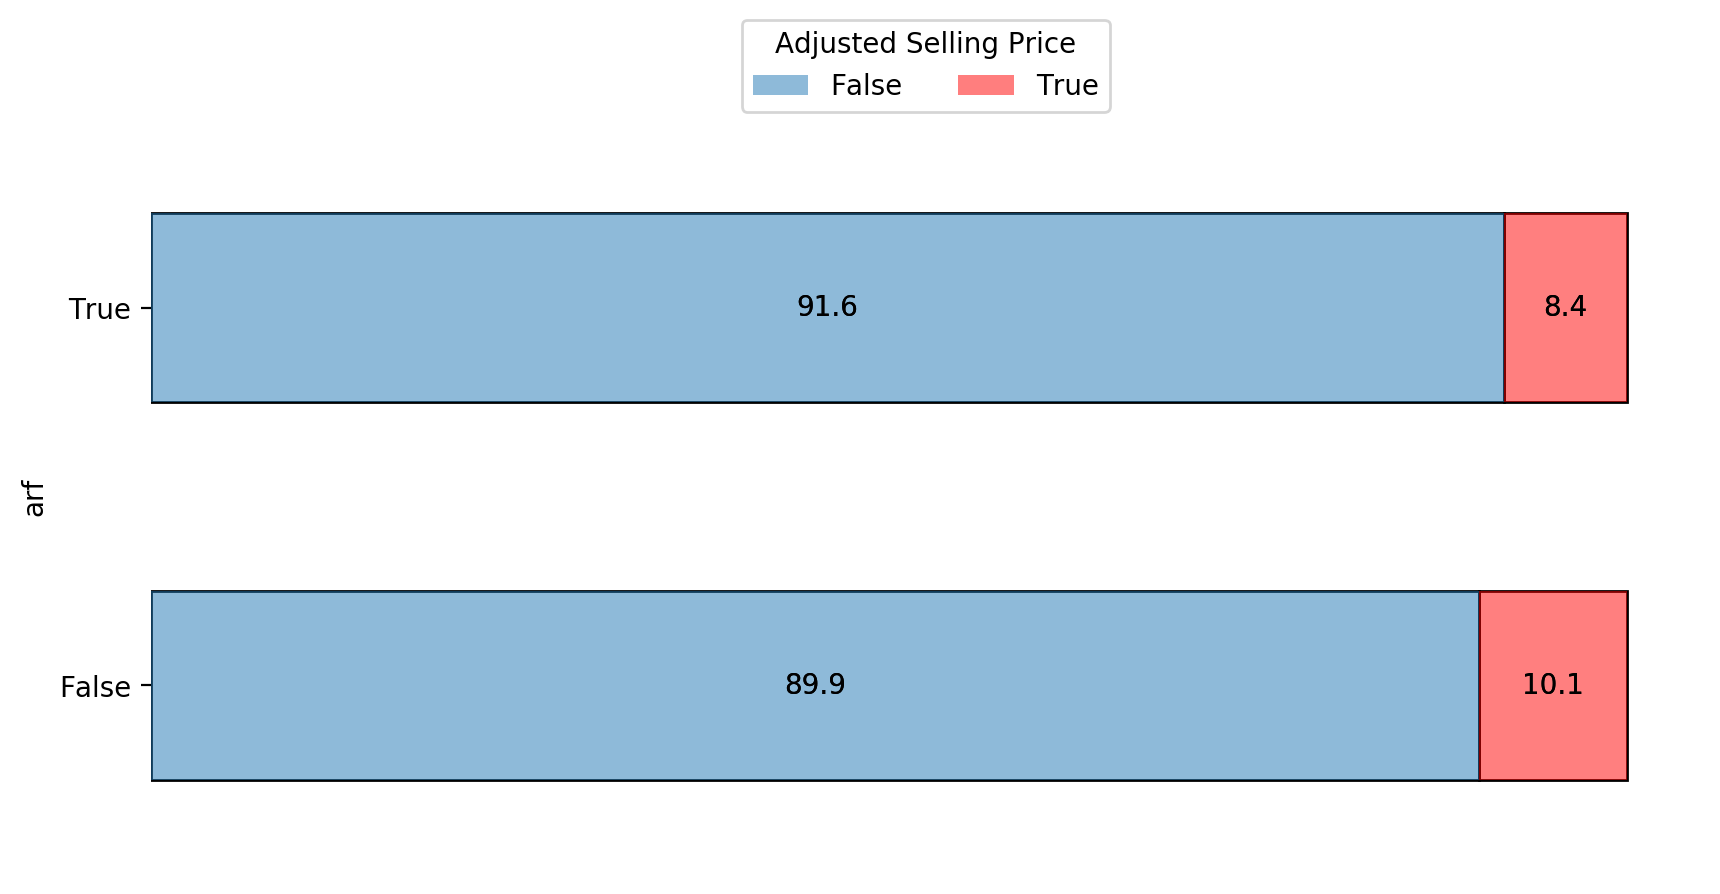

In [50]:
ct = pd.crosstab(df['arf'], df['has_price_drop'], normalize = 'index')

fig, ax = plt.subplots(figsize =  [10, 5])
ct.plot.barh(stacked = True, 
             ax = ax, 
             edgecolor = 'black',
             color = ['none', 'none'])
ct.plot.barh(stacked = True, 
             ax = ax,
             rot = 0, 
             color = ['#1f77b4', 'red'],
             alpha = .5)
ax.invert_yaxis() 

# make legends for right panel 
handles, labels = ax.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
ax.legend(by_label.values(), by_label.keys(),
          loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol = 2, title = 'Adjusted Selling Price')

# Value labels
patches = ax.patches
for rect in patches:
    width = rect.get_width()
    if width > 0:
        x = rect.get_x()
        y = rect.get_y()
        height = rect.get_height()
        ax.text(x + width/2., y + height/2., round(width*100, 1), ha='center', va='center')
        
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.invert_yaxis()
plt.xticks([])
plt.show()

In [72]:
%%R -i data -o model3_fit

# standardize time variables
data['me_'] <- scale(data$me)
data['w_'] <- scale(data$w)
data['me_2'] <- scale(data$me^2)
data['w_2'] <- scale(data$w^2)

# Create empty list for results
model3 <- list()

# Baseline Model
model3 <- append(model3, 
                 list(a = glm(has_price_drop_shift ~ 0,
                              data, 
                              family = binomial)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# empty
model3 <- append(model3, 
                 list(b = glmer(has_price_drop_shift ~ 0
                                + (1 | vendor),
                                data, 
                                family = binomial)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# Including control variables
model3 <- append(model3, 
                 list(c = glmer(has_price_drop_shift ~ 0
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial)))

# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted) 
# without interaction
Optimizer <- glmerControl(optimizer = "bobyqa",
                          optCtrl = list(maxfun=2e5))
model3 <- append(model3, 
                 list(d = glmer(has_price_drop_shift ~ bc_neg_count + arf
                                + bc_sales_volume_w + factor(international_shipment) 
                                + factor(arm_maxw) + me_ + me_2 + w_ + w_2
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial,
                                control = Optimizer)))


# Fixed effects cross classified model for (vendor/week) using
# two random intercepts on using arm at a time point (shifted)
# cross-level-interaction of ARF and Negative Feedbacks
model3 <- append(model3, 
                 list(e = glmer(has_price_drop_shift ~ bc_neg_count*arf
                                + bc_sales_volume_w + factor(international_shipment) 
                                + factor(arm_maxw) + me_ + me_2 + w_ + w_2
                                + (1 | vendor) + (1 | w),
                                data, 
                                family = binomial, 
                                control = Optimizer)))

model3_fit<- round(data.frame(t(anova(model3$b, model3$c, model3$d, model3$e))), 3)

R[write to console]: boundary (singular) fit: see ?isSingular



In [86]:
%%R -o model3_res
model3_res <- round(data.frame(summary(model3$e)[10]),3)
colnames(model3_res) <- c("B", 'se', 'z', 'p')
model3_res['or'] <- round(exp(model3_res$B), 3)
rownames(model3_res) <- c('Intercept', 'Negative feedbacks per week', 'ARF', 
                    'Sales per week', 'International Shipment', 
                    'Lowering of Selling Prices', 'Market Entry (in week since t0)',
                    'Market Entry (in weeks since t0)^2', 'Weeks since market entry phase', 
                    'Weeks since market entry phase^2', 'Negative feedbacks per week * ARF')

In [87]:
model3_fit

,model3.b,model3.c,model3.d,model3.e
npar,1.000,2.000,12.000,13.000
AIC,20544.125,15659.716,14752.448,14752.886
BIC,20552.198,15675.861,14849.318,14857.828
logLik,-10271.063,-7827.858,-7364.224,-7363.443
deviance,20542.125,15655.716,14728.448,14726.886
Chisq,NaN,4886.409,927.268,1.562
Df,NaN,1.000,10.000,1.000
Pr(>Chisq),NaN,0.000,0.000,0.211


In [88]:
model3_res

,B,se,z,p,or
Intercept,-2.199,0.123,-17.820,0.000,0.111
Negative feedbacks per week,0.234,0.025,9.527,0.000,1.264
ARF,-0.084,0.115,-0.731,0.465,0.919
Sales per week,-0.746,0.027,-27.399,0.000,0.474
International Shipment,-0.005,0.046,-0.119,0.905,0.995
Lowering of Selling Prices,0.619,0.141,4.372,0.000,1.857
Market Entry (in week since t0),-0.424,0.061,-6.906,0.000,0.654
Market Entry (in weeks since t0)^2,0.199,0.062,3.201,0.001,1.220
Weeks since market entry phase,-1.853,0.418,-4.429,0.000,0.157
Weeks since market entry phase^2,1.286,0.375,3.433,0.001,3.618


In [37]:
temp = pd.concat([df['neg_count_min'], round(data['bc_neg_count_min'], 2)], axis = 1)
print(temp.loc[temp['bc_neg_count_min'].between(.2, .22), 'neg_count_min'].mean())
print(temp.loc[temp['bc_neg_count_min'].between(-.09, -.06), 'neg_count_min'].mean())
print(temp.loc[temp['bc_neg_count_min'].between(-.01, .01), 'neg_count_min'].mean())

12.0
7.0
8.0
